Рустам Шамсутдинов БВТ2201

In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
noise_factor = 0.5
batch_size = 128
epochs = 50
num_display = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
x_train = torch.stack([img for img,_ in train_ds])
x_test = torch.stack([img for img,_ in test_ds])

In [ ]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, nonlinearity='relu')
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, x):
        return torch.matmul(x, self.weight.t()) + self.bias

    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'

class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.maximum(torch.tensor(0.0, device=x.device), x)

class CustomSigmoid(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.where(
            x >= 0,
            1 / (1 + torch.exp(-x)),
            torch.exp(x) / (1 + torch.exp(x))
        )

In [5]:
# class AE(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(28*28, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),  # latent vector
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, 28*28),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         z = self.encoder(x)
#         out = self.decoder(z)
#         out = out.view(x.size(0), 1, 28, 28)
#         return out

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            CustomLinear(28*28, 128),
            CustomReLU(),
            CustomLinear(128, 64),
            CustomReLU(),
            CustomLinear(64, 32),  # latent vector
        )
        self.decoder = nn.Sequential(
            CustomLinear(32, 64),
            CustomReLU(),
            CustomLinear(64, 128),
            CustomReLU(),
            CustomLinear(128, 28*28),
            CustomSigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        out = self.decoder(z)
        out = out.view(x.size(0), 1, 28, 28)
        return out

In [6]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

x_train_noisy = torch.clamp(x_train + noise_factor * torch.randn_like(x_train), 0., 1.)
x_test_noisy  = torch.clamp(x_test  + noise_factor * torch.randn_like(x_test), 0., 1.)

train_loader = DataLoader(TensorDataset(x_train_noisy, x_train), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(x_test_noisy, x_test),  batch_size=batch_size, shuffle=False)

In [7]:
model = AE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []
for epoch in range(1, epochs+1):
    model.train()
    running, count = 0.0, 0
    for xb_noisy, xb_clean in train_loader:
        xb_noisy, xb_clean = xb_noisy.to(device), xb_clean.to(device)
        optimizer.zero_grad()
        out = model(xb_noisy)
        loss = criterion(out, xb_clean)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb_noisy.size(0)
        count += xb_noisy.size(0)

    train_loss = running / count
    train_losses.append(train_loss)

    model.eval()
    running, count = 0.0, 0
    with torch.no_grad():
        for xb_noisy, xb_clean in test_loader:
            xb_noisy, xb_clean = xb_noisy.to(device), xb_clean.to(device)
            out = model(xb_noisy)
            loss = criterion(out, xb_clean)
            running += loss.item() * xb_noisy.size(0)
            count += xb_noisy.size(0)

    val_loss = running / count
    val_losses.append(val_loss)

    print(f"Epoch {epoch}/{epochs} — train_loss {train_loss:.6f}, val_loss {val_loss:.6f}")

Epoch 1/50 — train_loss 0.055400, val_loss 0.036196
Epoch 2/50 — train_loss 0.033802, val_loss 0.031329
Epoch 3/50 — train_loss 0.030364, val_loss 0.028819
Epoch 4/50 — train_loss 0.028194, val_loss 0.027268
Epoch 5/50 — train_loss 0.026879, val_loss 0.026035
Epoch 6/50 — train_loss 0.026005, val_loss 0.025605
Epoch 7/50 — train_loss 0.025371, val_loss 0.024928
Epoch 8/50 — train_loss 0.024783, val_loss 0.024400
Epoch 9/50 — train_loss 0.024197, val_loss 0.024043
Epoch 10/50 — train_loss 0.023620, val_loss 0.023343
Epoch 11/50 — train_loss 0.023138, val_loss 0.023159
Epoch 12/50 — train_loss 0.022747, val_loss 0.022722
Epoch 13/50 — train_loss 0.022424, val_loss 0.022382
Epoch 14/50 — train_loss 0.022115, val_loss 0.022216
Epoch 15/50 — train_loss 0.021847, val_loss 0.022060
Epoch 16/50 — train_loss 0.021565, val_loss 0.021565
Epoch 17/50 — train_loss 0.021243, val_loss 0.021332
Epoch 18/50 — train_loss 0.020903, val_loss 0.021171
Epoch 19/50 — train_loss 0.020589, val_loss 0.021049
Ep

Средняя MSE: 0.01826464


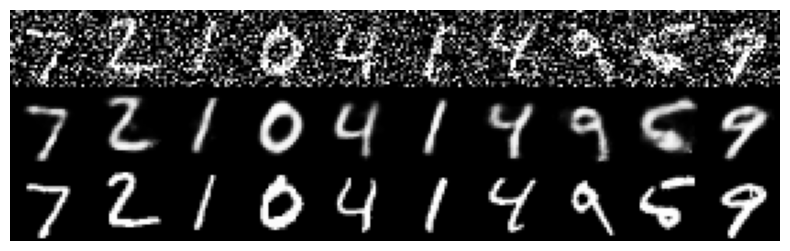

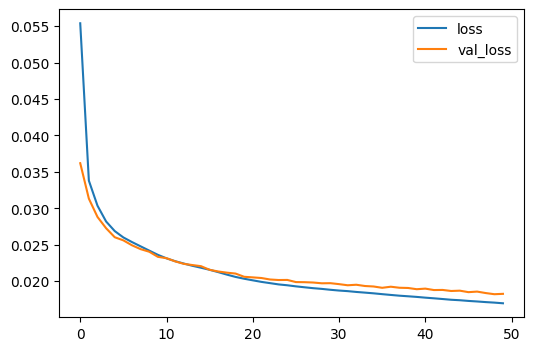

In [8]:
model.eval()
with torch.no_grad():
    decoded = model(x_test_noisy.to(device)).cpu().numpy()
x_test_np = x_test.numpy()
mse_all = np.mean((decoded - x_test_np)**2)
print("Средняя MSE:", mse_all)

display_n = min(num_display, decoded.shape[0])
rows = []
for i in range(display_n):
    noisy = (x_test_noisy[i].numpy().squeeze() * 255).astype(np.uint8)
    den   = (decoded[i].squeeze() * 255).astype(np.uint8)
    clean = (x_test_np[i].squeeze() * 255).astype(np.uint8)
    vert = np.vstack([noisy, den, clean])
    rows.append(vert)
grid = np.hstack(rows)
plt.figure(figsize=(display_n, 3))
plt.axis('off')
plt.imshow(grid, cmap='gray', vmin=0, vmax=255)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.legend()
plt.show()